## 9. 시계열을 위한 머신러닝

### 9.1.1

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


cesium github: https://github.com/cesium-ml/cesium/tree/main

In [19]:
eeg

{'times': [array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00

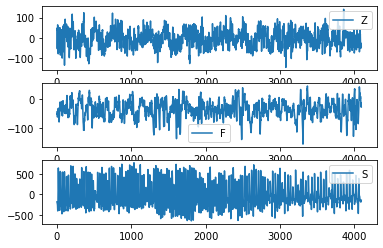

In [20]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg['measurements'][450])
plt.legend(eeg['classes'][450])

- eeg 데이터셋 중 임의로 선택된 세 개의 표본에 대한 그래프
- 이들은 서로 독립적 & 서로 다른 시간에 서로 다른 환자를 대상으로 측정한 독립적인 시계열임
- Z와 F는 S보다 덜 편향 & y축의 각 범주는 꽤 다른 범위의 값으로 구성됨 => 진폭이 유용할 수 있다는 점 시사

### 특징 생성

In [21]:
import sys
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [22]:
import cesium
print(cesium.__version__)

0.12.1


In [23]:
from cesium.featurize import featurize_time_series as ft

In [24]:
features_to_use = ['amplitude',
                  "percent_beyond_1_std",
                  "percent_close_to_median",
                  "skew",
                  "max_slope"]
fset_cesium = ft(times = eeg['times'],
                values = eeg['measurements'],
                errors = None,
                features_to_use = features_to_use,
                scheduler = None)

In [25]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


- 특징이 나타내려는 것 이해 & 이해한 바가 cesium의 계산과 일치한지 확인 필요

### 9.1.2

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg['classes'], random_state=21)

In [27]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                               max_depth = 3,
                               random_state = 21)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [28]:
rf_clf.score(X_test, y_test)

0.616

In [29]:
# XGBoost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                           max_depth = 3,
                           random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

[13:43:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\MJHwang\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\MJHwang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.688

성능이 XGBoost가 더 좋을 뿐더러, RandomFores(배깅)가 XGBoost(부스팅)보다 약 50% 이상의 시간 더 사용함

In [35]:
# DTW 구현
def distDTW(ts1, ts2):
    DTW = {}
    for i in range(len(ts1)):
        DTW[(i, -1)] = np.inf
    for i in range(len(ts2)):
        DTW[(-1, i)] = np.inf
    DTW[(-1, -1)] = 0
    
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],
                                     DTW[(i, j-1)],
                                     DTW[(i-1, j-1)])
    return sqrt(DTW[len(ts1)-1, len(ts2)-1])

In [38]:
from sklearn import preprocessing
word = pd.read_csv("C:/Users/MJHwang/Desktop/tobigs/FiftyWords_TRAIN.txt")

In [39]:
word

9.0000000e+00  -7.9041907e-01  -7.6517067e-01  -7.3354192e-01  -6.9963343e-01  -6.6773990e-01  -6.3863252e-01  -6.1180824e-01  -5.8728213e-01  -5.6430137e-01  -5.4438116e-01  -5.2935343e-01  -5.1750211e-01  -5.0886727e-01  -5.0227876e-01  -4.9418748e-01  -4.8776688e-01  -4.8243639e-01  -4.7509291e-01  -4.7221693e-01  -4.6985034e-01  -4.6458592e-01  -4.6352343e-01  -4.6142804e-01  -4.5761020e-01  -4.5909288e-01  -4.6013627e-01  -4.5922559e-01  -4.5787671e-01  -4.4818572e-01  -4.3071135e-01  -4.0775787e-01  -3.7470450e-01  -3.3276406e-01  -2.7680396e-01  -1.9645398e-01  -9.0298441e-02   4.7421453e-02   2.2049558e-01   4.2610361e-01   6.7132644e-01   9.6248352e-01   1.3001520e+00   1.6832044e+00   2.0961073e+00   2.5103437e+00   2.8950931e+00   3.2193575e+00   3.4627502e+00   3.6209759e+00   3.6996185e+00   3.7128996e+00   3.6774581e+00   3.6058883e+00   3.5102093e+00   3.3997355e+00   3.2801471e+00   3.1583924e+00   3.0381276e+00   2.9193476e+00   2.8006421e+00   2.6759728e+00   2.5378207e+00   2.3816771e+00   2.2061284e+00   2.0161922e+00   1.8207789e+00   1.6266062e+00   1.4393082e+00   1.2597058e+00   1.0846672e+00   9.1676268e-01   7.5765525e-01   6.0807585e-01   4.7629319e-01   3.6105720e-01   2.5887282e-01   1.7308743e-01   9.6470901e-02   2.6893708e-02  -3.2235560e-02  -8.7307355e-02  -1.3689786e-01  -1.7931348e-01  -2.2132750e-01  -2.5954886e-01  -2.9337686e-01  -3.2833837e-01  -3.5883947e-01  -3.8533967e-01  -4.1341732e-01  -4.3700113e-01  -4.5785304e-01  -4.8018824e-01  -4.9755043e-01  -5.1223386e-01  -5.2641307e-01  -5.3600246e-01  -5.4404561e-01  -5.5163961e-01  -5.5637762e-01  -5.6113386e-01  -5.6548881e-01  -5.6758832e-01  -5.6959311e-01  -5.6965820e-01  -5.6603235e-01  -5.6025886e-01  -5.4948076e-01  -5.3220073e-01  -5.0995844e-01  -4.8014676e-01  -4.4343151e-01  -4.0240422e-01  -3.5674879e-01  -3.0783143e-01  -2.5630061e-01  -2.0003657e-01  -1.3875290e-01  -7.2699835e-02  -2.8484367e-03   6.6369127e-02   1.3058510e-01   1.8612463e-01   2.2914710e-01   2.5895140e-01   2.7589944e-01   2.7963466e-01   2.7232154e-01   2.5625046e-01   2.3374145e-01   2.0940933e-01   1.8571945e-01   1.6233944e-01   1.3868590e-01   1.1208860e-01   8.0643694e-02   4.5686474e-02   7.8176486e-03  -3.1699830e-02  -7.0879361e-02  -1.0997320e-01  -1.4719217e-01  -1.8032289e-01  -2.0995324e-01  -2.3490907e-01  -2.5589810e-01  -2.7537219e-01  -2.9211560e-01  -3.0676437e-01  -3.2039142e-01  -3.3220876e-01  -3.4380844e-01  -3.5484313e-01  -3.6276972e-01  -3.6672638e-01  -3.6360888e-01  -3.5115612e-01  -3.3013439e-01  -2.9944111e-01  -2.6041452e-01  -2.1723621e-01  -1.7179645e-01  -1.2815208e-01  -9.0836343e-02  -5.9734887e-02  -3.6371634e-02  -2.1981298e-02  -1.5890106e-02  -2.0297528e-02  -3.6848721e-02  -6.4751740e-02  -1.0373446e-01  -1.5089977e-01  -2.0148616e-01  -2.5293094e-01  -3.0207510e-01  -3.4682678e-01  -3.8840782e-01  -4.2620087e-01  -4.5982499e-01  -4.9065951e-01  -5.1697612e-01  -5.3882444e-01  -5.5823452e-01  -5.7462167e-01  -5.8841609e-01  -5.9955491e-01  -6.0571570e-01  -6.0697561e-01  -6.0414853e-01  -5.9770612e-01  -5.8913275e-01  -5.7675455e-01  -5.5773489e-01  -5.3127907e-01  -4.9612068e-01  -4.5409957e-01  -4.0952576e-01  -3.6356431e-01  -3.1830811e-01  -2.7612295e-01  -2.3687167e-01  -2.0281675e-01  -1.7610459e-01  -1.5669304e-01  -1.4539933e-01  -1.4200161e-01  -1.4501179e-01  -1.5404540e-01  -1.6792038e-01  -1.8514938e-01  -2.0585993e-01  -2.2969283e-01  -2.5635975e-01  -2.8637844e-01  -3.1835697e-01  -3.5073517e-01  -3.8311750e-01  -4.1367390e-01  -4.4168825e-01  -4.6729507e-01  -4.8927889e-01  -5.0759369e-01  -5.2278845e-01  -5.3471219e-01  -5.4437693e-01  -5.5209433e-01  -5.5728151e-01  -5.6031352e-01  -5.6033488e-01  -5.5690388e-01  -5.5111378e-01  -5.4235654e-01  -5.3119043e-01  -5.1936578e-01  -5.0656079e-01  -4.9433549e-01  -4.8419196e-01  -4.7553422e-01  -4.6873425e-01  -4.6285870e-01  -4.5628811e-01  -4.4930162e-01  -4.4202663e-01  -4.3525796e-01  -4.3085639e-01  -4.2918720e-01  -4.3046546e-01  -4.3509043e-01  -